# Model Selection & Training

## Importing neccessary packages

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Engineering the Response variable

Below, we derive a response variable called "Demand_Score", which allocates a score estimating the level of demand for the particular attraction. This score is derived from the average of 2 standardized variables, "Max_wait_time_std" and "Total_units_std". We standardize them as we do not want either of the 2 variables to dominate over the other when computing the score, especially since we observe that "Total_units" has significantly larger values than "Max_wait_time".

In [6]:
df = pd.read_csv("output.csv")
scaler = StandardScaler()

# Standardize the variables to be used for deriving the response variable (demand score)
df[["Max_wait_time_std", "Total_units_std"]] = scaler.fit_transform(df[["Max_wait_time", "Total_units"]])
df.drop(columns=["Max_wait_time","Total_units"], inplace=True)

df["Demand_Score"] = (df["Max_wait_time_std"] + df["Total_units_std"]) / 2
df.drop(columns=["Max_wait_time_std","Total_units_std","Year_Month"], inplace=True)
df.head(5)

,Park_Fatalities_Previous_Year,Fraction of Not Rainy,Fraction of Rainy,Drought Count,Flooding Count,Freeze Count,Severe Storm Count,Tropical Cyclone Count,Wildfire Count,Winter Storm Count,...,Attraction_Spinning Coaster,Attraction_Spiral Slide,Attraction_Superman Ride,Attraction_Swing Ride,Attraction_Tilt-A-Whirl,Attraction_Top Spin,Attraction_Vertical Drop,Attraction_Water Ride,Attraction_Zipline,Demand_Score
0,2,0.935484,0.064516,0.0,0.0,0.0,0.166667,0.083333,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.267251
1,2,0.935484,0.064516,0.0,0.0,0.0,0.166667,0.083333,0.0,0.0,...,0,0,0,0,0,0,0,0,0,-0.137697
2,2,0.935484,0.064516,0.0,0.0,0.0,0.166667,0.083333,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.375315
3,2,0.935484,0.064516,0.0,0.0,0.0,0.166667,0.083333,0.0,0.0,...,0,0,0,0,0,0,0,0,0,-0.635457
4,2,0.935484,0.064516,0.0,0.0,0.0,0.166667,0.083333,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.002851


In [7]:
df.columns.unique()

Index(['Park_Fatalities_Previous_Year', 'Fraction of Not Rainy',
       'Fraction of Rainy', 'Drought Count', 'Flooding Count', 'Freeze Count',
       'Severe Storm Count', 'Tropical Cyclone Count', 'Wildfire Count',
       'Winter Storm Count', 'All Disasters Count', 'Public_Holidays_in_Month',
       'Spring', 'Summer', 'Autumn', 'Winter', 'Ongoing Disasters',
       'Avg_no_parades', 'Average_attendee_seaworld', 'Attraction_Bumper Cars',
       'Attraction_Bungee Jump', 'Attraction_Circus Train',
       'Attraction_Crazy Bus', 'Attraction_Crazy Dance',
       'Attraction_Dizzy Dropper', 'Attraction_Drop Tower',
       'Attraction_Flying Coaster', 'Attraction_Free Fall',
       'Attraction_Giant Wheel', 'Attraction_Giga Coaster',
       'Attraction_Go-Karts', 'Attraction_Gondola', 'Attraction_Haunted House',
       'Attraction_Himalaya Ride', 'Attraction_Inverted Coaster',
       'Attraction_Kiddie Coaster', 'Attraction_Log Flume',
       'Attraction_Merry Go Round', 'Attraction_Mono

## Train-Test Split

For the different methods below, we will use only the training data in our model training and selection process, leaving the test data unseen. The test data will be reserved for evaluating our final selected model, based on lowest average Cross-Validated (CV) RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error).

In [8]:
# Features and target variable
X = df.drop(columns=["Demand_Score"])  # Features
y = df["Demand_Score"]  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verifying split sizes
print(f"Training data size: {X_train.shape[0]} samples")
print(f"Test data size: {X_test.shape[0]} samples")

Training data size: 1662 samples
Test data size: 416 samples


## Linear Regression

In [9]:
# Linear Regression
lr_model = LinearRegression()

# Cross-validation for RMSE 
rmse_scores_lr = cross_val_score(lr_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
average_rmse_lr = np.mean(np.sqrt(np.abs(rmse_scores_lr)))

# Cross-validation for MAE
mae_scores_lr = cross_val_score(lr_model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
average_mae_lr = np.mean(np.abs(mae_scores_lr))  


## Standardizing features for Ridge, Lasso, and Elastic Net

Ridge, Lasso and Elastic Net are sensitive to feature scales, so we standardize the features in our training data before proceeding with these 3 models.

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scaling features in training data only
X_test_scaled = scaler.transform(X_test)  # Transforming test data (for possible later evaluation)

## Ridge Regression

In [13]:
# Ridge Regression (Finding optimal alpha using training data)
ridge_params = {'alpha': np.logspace(-1, 3, 50)}
ridge_grid = GridSearchCV(Ridge(), ridge_params, scoring="neg_mean_squared_error", cv=5)
ridge_grid.fit(X_train_scaled, y_train)

optimal_alpha_ridge = ridge_grid.best_params_['alpha']  # Best alpha value

# Train Ridge model with optimal alpha
ridge_model = Ridge(alpha=optimal_alpha_ridge)

# Cross-validation for RMSE
rmse_scores_ridge = cross_val_score(ridge_model, X_train_scaled, y_train, cv=5, scoring="neg_mean_squared_error")
average_rmse_ridge = np.mean(np.sqrt(np.abs(rmse_scores_ridge)))  

# Cross-validation for MAE
mae_scores_ridge = cross_val_score(ridge_model, X_train_scaled, y_train, cv=5, scoring="neg_mean_absolute_error")
average_mae_ridge = np.mean(np.abs(mae_scores_ridge)) 

## Lasso Regression

In [14]:
# Lasso Regression (Finding optimal alpha using training data)
lasso_params = {'alpha': np.logspace(-3, 3, 50)}  
lasso_grid = GridSearchCV(Lasso(max_iter=10000), lasso_params, scoring="neg_mean_squared_error", cv=5)
lasso_grid.fit(X_train_scaled, y_train)

optimal_alpha_lasso = lasso_grid.best_params_['alpha']  # Best alpha value

# Train Lasso model with optimal alpha
lasso_model = Lasso(alpha=optimal_alpha_lasso, max_iter=10000)

# Cross-validation for RMSE
rmse_scores_lasso = cross_val_score(lasso_model, X_train_scaled, y_train, cv=5, scoring="neg_mean_squared_error")
average_rmse_lasso = np.mean(np.sqrt(np.abs(rmse_scores_lasso)))  

# Cross-validation for MAE
mae_scores_lasso = cross_val_score(lasso_model, X_train_scaled, y_train, cv=5, scoring="neg_mean_absolute_error")
average_mae_lasso = np.mean(np.abs(mae_scores_lasso))  



## Elastic Net Regression (Combining L1 and L2 regularization)

In [15]:
# Elastic Net Regression (Finding optimal alpha and l1_ratio using training data)
elastic_params = {
    'alpha': np.logspace(-3, 3, 30),  
    'l1_ratio': np.linspace(0.1, 0.9, 9) 
}
elastic_grid = GridSearchCV(ElasticNet(max_iter=10000), elastic_params, scoring="neg_mean_squared_error", cv=5)
elastic_grid.fit(X_train_scaled, y_train)

optimal_alpha_elastic = elastic_grid.best_params_['alpha']
optimal_l1_ratio = elastic_grid.best_params_['l1_ratio']

# Train Elastic Net model with optimal alpha and l1_ratio
elastic_model = ElasticNet(alpha=optimal_alpha_elastic, l1_ratio=optimal_l1_ratio, max_iter=10000)

# Cross-validation for RMSE
rmse_scores_elastic = cross_val_score(elastic_model, X_train_scaled, y_train, cv=5, scoring="neg_mean_squared_error")
average_rmse_elastic = np.mean(np.sqrt(np.abs(rmse_scores_elastic)))  

# Cross-validation for MAE
mae_scores_elastic = cross_val_score(elastic_model, X_train_scaled, y_train, cv=5, scoring="neg_mean_absolute_error")
average_mae_elastic = np.mean(np.abs(mae_scores_elastic))  


## Single Decision Tree

In [18]:
dt_model = DecisionTreeRegressor(random_state=42)

# Defining hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# RMSE Tuning
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

grid_rmse = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1
)

grid_rmse.fit(X_train, y_train)  

# MAE Tuning
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid_mae = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=5,
    n_jobs=-1
)

grid_mae.fit(X_train, y_train)

# Tuned Decision Tree (RMSE)
optimal_params_dt_rmse = grid_rmse.best_params_
average_rmse_dt_tuned = -grid_rmse.best_score_

# Tuned Decision Tree (MAE)
optimal_params_dt_mae = grid_mae.best_params_
average_mae_dt_tuned = -grid_mae.best_score_

## Random Forest

In [19]:
rf_model = RandomForestRegressor(random_state=42)

# Defining hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# RMSE Tuning
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

grid_rf_rmse = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1
)

grid_rf_rmse.fit(X_train, y_train)

# MAE Tuning
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid_rf_mae = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring=mae_scorer,
    cv=5,
    n_jobs=-1
)

grid_rf_mae.fit(X_train, y_train)

# Tuned Random Forest (RMSE)
optimal_params_rf_rmse = grid_rf_rmse.best_params_
average_rmse_rf_tuned = -grid_rf_rmse.best_score_

# Tuned Random Forest (MAE)
optimal_params_rf_mae = grid_rf_mae.best_params_
average_mae_rf_tuned = -grid_rf_mae.best_score_

## Overall results (Average CV RMSE and MAE)

In [20]:
print(f"Average CV RMSE for Multiple Linear Regression: {average_rmse_lr:.4f}")
print(f"Average CV MAE for Multiple Linear Regression: {average_mae_lr:.4f}")
print(f"Optimal Ridge Penalty: {optimal_alpha_ridge:.4f}")
print(f"Average CV RMSE for Ridge Regression: {average_rmse_ridge:.4f}")
print(f"Average CV MAE for Ridge Regression: {average_mae_ridge:.4f}")
print(f"Optimal Lasso Penalty: {optimal_alpha_lasso:.4f}")
print(f"Average CV RMSE for Lasso Regression: {average_rmse_lasso:.4f}")
print(f"Average CV MAE for Lasso Regression: {average_mae_lasso:.4f}")
print(f"Optimal Elastic Net Alpha: {optimal_alpha_elastic:.4f}, L1 Ratio: {optimal_l1_ratio:.2f}")
print(f"Average CV RMSE for Elastic Net Regression: {average_rmse_elastic:.4f}")
print(f"Average CV MAE for Elastic Net Regression: {average_mae_elastic:.4f}")
print(f"Optimal Parameters for Decision Tree (RMSE): {optimal_params_dt_rmse}")
print(f"Average CV RMSE for Tuned Decision Tree: {average_rmse_dt_tuned:.4f}")
print(f"Optimal Parameters for Decision Tree (MAE): {optimal_params_dt_mae}")
print(f"Average CV MAE for Tuned Decision Tree: {average_mae_dt_tuned:.4f}")
print(f"Optimal Parameters for Random Forest (RMSE): {optimal_params_rf_rmse}")
print(f"Average CV RMSE for Tuned Random Forest: {average_rmse_rf_tuned:.4f}")
print(f"Optimal Parameters for Random Forest (MAE): {optimal_params_rf_mae}")
print(f"Average CV MAE for Tuned Random Forest: {average_mae_rf_tuned:.4f}")

Average CV RMSE for Multiple Linear Regression: 0.5770
Average CV MAE for Multiple Linear Regression: 0.3850
Optimal Ridge Penalty: 19.3070
Average CV RMSE for Ridge Regression: 0.5767
Average CV MAE for Ridge Regression: 0.3840
Optimal Lasso Penalty: 0.0018
Average CV RMSE for Lasso Regression: 0.5769
Average CV MAE for Lasso Regression: 0.3844
Optimal Elastic Net Alpha: 0.0108, L1 Ratio: 0.10
Average CV RMSE for Elastic Net Regression: 0.5768
Average CV MAE for Elastic Net Regression: 0.3841
Optimal Parameters for Decision Tree (RMSE): {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Average CV RMSE for Tuned Decision Tree: 0.5573
Optimal Parameters for Decision Tree (MAE): {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Average CV MAE for Tuned Decision Tree: 0.3180
Optimal Parameters for Random Forest (RMSE): {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Average CV RMSE for Tuned Random Forest: 0.4889


## Plots for RMSE and MAE for the different models

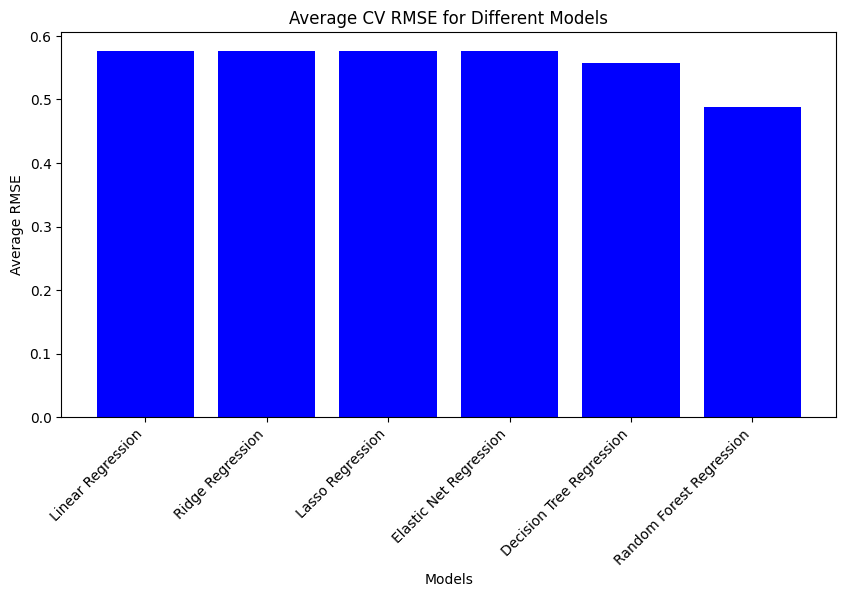

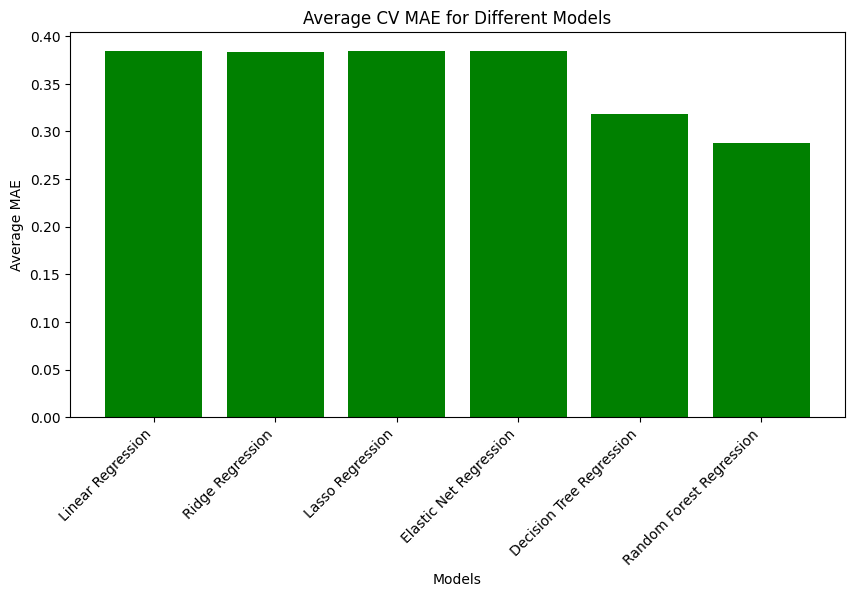

In [21]:
models = [
    "Linear Regression", "Ridge Regression", "Lasso Regression", "Elastic Net Regression",
    "Decision Tree Regression", "Random Forest Regression"
]
# RMSE values
rmse_values = [
    average_rmse_lr, average_rmse_ridge, average_rmse_lasso, average_rmse_elastic,
    average_rmse_dt_tuned, average_rmse_rf_tuned
]

# MAE values
mae_values = [
    average_mae_lr, average_mae_ridge, average_mae_lasso, average_mae_elastic,
    average_mae_dt_tuned, average_mae_rf_tuned
]

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.bar(models, rmse_values, color='blue')
plt.xlabel("Models")
plt.ylabel("Average RMSE")
plt.title("Average CV RMSE for Different Models")
plt.xticks(rotation=45, ha="right")
plt.show()

# Plot MAE
plt.figure(figsize=(10, 5))
plt.bar(models, mae_values, color='green')
plt.xlabel("Models")
plt.ylabel("Average MAE")
plt.title("Average CV MAE for Different Models")
plt.xticks(rotation=45, ha="right")
plt.show()

Above, we observe from the 2 plots that the Random Forest Regression model outperforms the other models in terms of both average 5-fold CV RMSE and MAE as evaluation metrics. So we conclude that Random Forest Regressor will be our final predictive model for this task to predict the demand score for each attraction.

## Feature Importance for Random Forest model

In [25]:
# Using the optimally tuned Random Forest model (RMSE-based)
best_rf_model = grid_rf_rmse.best_estimator_
best_rf_model.fit(X_train, y_train)
feature_importance = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by="Importance", ascending=False)
print(feature_importance_df)

                          Feature  Importance
36           Attraction_Log Flume    0.119671
37      Attraction_Merry Go Round    0.087506
24       Attraction_Dizzy Dropper    0.070792
7          Tropical Cyclone Count    0.069210
1           Fraction of Not Rainy    0.054726
2               Fraction of Rainy    0.054699
45          Attraction_Scooby Doo    0.049671
18      Average_attendee_seaworld    0.048784
17                 Avg_no_parades    0.037713
12                         Spring    0.035021
0   Park_Fatalities_Previous_Year    0.028311
11       Public_Holidays_in_Month    0.026156
43      Attraction_Reverse Bungee    0.022171
53            Attraction_Top Spin    0.020067
33       Attraction_Himalaya Ride    0.019960
21        Attraction_Circus Train    0.018682
23         Attraction_Crazy Dance    0.018199
15                         Winter    0.018051
39          Attraction_Oz Theatre    0.017433
40         Attraction_Pirate Ship    0.017279
10            All Disasters Count 

Above, we obtain a feature importance table. Interestingly, we observe that the Log-Fume, Merry-Go-Round and Dizzy-Dropper attractions are listed as more important than the presence of nearby cyclone risks and whether it is raining or not. This may imply that these rides inherently drive the level of demand. An interesting thought is whether park visitors will still visit these three attractions even when adverse weather conditions are prevalent, as the inherent appeal of these three attractions may overshadow the banes caused by adverse weather. Theme park owners can leverage on this knowledge by enhancing these three rides to sustain their appeal, and if business goals involve mitigating the impact of adverse weather conditions on attraction demand, businesses may also consider installing more sheltered infrastructure within areas vulnerable to adverse weather conditions.

## Evaluating Test RMSE and MAE for Tuned Random Forest Model

In [24]:
y_pred_rf = best_rf_model.predict(X_test)
# Test RMSE
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
# Test MAE
mae_test_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Test RMSE for Tuned Random Forest: {rmse_test_rf:.4f}")
print(f"Test MAE for Tuned Random Forest: {mae_test_rf:.4f}")

Test RMSE for Tuned Random Forest: 0.4871
Test MAE for Tuned Random Forest: 0.3073


Lastly, we evaluate the test RMSE and MAE for the Random Forest model. We observe that the RMSE and MAE using unseen test data are close to those when using 5-fold CV for this model. This suggests that using cross-validation provides a realistic estimate of model performance on unseen data.